In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


# Tracks Reconstruction

In [4]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator
from retina import Retina2DTrackerOne


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [40]:
__author__ = 'mikhail91'

import numpy
import pandas
from sklearn.linear_model import LinearRegression
from copy import deepcopy
import itertools

class ImprovedTemplateMatching(object):

    def __init__(self, n_tracks, n_max_hits, n_min_hits, window_width, lambda_, T):
        """
        This class is simple realization of a Template Matching paradigm for straight tracks in 2D.
        :param n_max_hits: int, max min number of hits to consider the track recognized.
        :param n_min_hits: int, min min number of hits to consider the track recognized.
        :param window_width: float, width of a searching window for searching hits for a track.
        :return:
        """

        self.n_tracks = n_tracks
        self.window_width = window_width
        self.n_max_hits = n_max_hits
        self.n_min_hits = n_min_hits
        self.lambda_ = lambda_
        self.T = T
        
        
    def energy(self, params, x, y, lambda_=0., T=1.):
        
        params = numpy.array(params)

        beta = 1. / T

        dists = (y - x * params[:, 0].reshape(-1, 1) - params[:, 1].reshape(-1, 1)).T

        E = - 1./beta * (numpy.log(numpy.exp(-beta * lambda_) + numpy.exp(-beta * dists**2).sum(axis=1))).sum()

        return E

    def fit(self, x, y, sample_weight=None):
        """
        Fit the method.
        :param x: numpy.ndarray shape=[n_hits, n_features], X of hits.
        :param y: numpy.array shape=[n_hits], y of hits.
        :param sample_weight: numpy.array shape=[n_hits], weight of each hits.
        :return:
        """

        used = numpy.zeros(len(x))
        labels = -1. * numpy.ones(len(x))
        track_id = 0
        tracks_params = []
        tracks = []

        #for n_hits in range(self.n_min_hits, self.n_max_hits+1)[::-1]:

        for first_ind in range(len(x)):

            for second_ind in range(len(x)):

                x1 = x[first_ind]
                y1 = y[first_ind]

                x2 = x[second_ind]
                y2 = y[second_ind]

                if (x1 >= x2) or (used[first_ind] == 1) or (used[second_ind] == 1):
                    continue

                k = 1. * (y2 - y1) / (x2 - x1)
                b = y1 - k * x1

                y_upper = b + k * x.reshape(-1) + self.window_width
                y_lower = b + k * x.reshape(-1) - self.window_width

                track = (y <= y_upper) * (y >= y_lower) * (used == 0)

                track_x = x[track]
                track_y = y[track]
                track_index = numpy.arange(len(x))[track]

                [k, b] = numpy.polyfit(track_x, track_y, 1)
                dist = (track_y - track_x * k - b)**2

                unique_x = numpy.unique(track_x)
                new_track_index = []

                for x_one in unique_x:

                    ind_one = track_index[track_x == x_one]
                    dist_one = dist[track_x == x_one]

                    new_ind_one = ind_one[(dist_one == dist_one.min())][0]

                    new_track_index.append(new_ind_one)

                new_track_index = numpy.array(new_track_index)

                track = numpy.in1d(range(len(x)), new_track_index)


                if track.sum() >= self.n_min_hits:

                    #used[track] = 1
                    tracks.append(track)
                    #labels[track] = track_id
                    track_id += 1

                    x_track = x[track]
                    y_track = y[track]

                    if sample_weight != None:
                        sample_weight_track = sample_weight[track]
                    else:
                        sample_weight_track = None

                    lr = LinearRegression()
                    lr.fit(x_track.reshape(-1,1), y_track, sample_weight_track)

                    params = list(lr.coef_) + [lr.intercept_]
                    tracks_params.append(params)
                    
            
        start = 1
        min_E = 0
        best_params = []
        best_set = None
            
        for one_set in itertools.combinations(range(len(tracks_params)), self.n_tracks):
            
            params = []
            
            for i in one_set:
                
                params.append(tracks_params[i])
                
            params = numpy.array(params)
            E = self.energy(params, x, y, lambda_=self.lambda_, T = self.T)
            
            if start:
                
                min_E = E
                best_set = deepcopy(one_set)
                best_params = deepcopy(params)
                start = 0
                
            if E < min_E:
                
                min_E = E
                best_set = deepcopy(one_set)
                best_params = deepcopy(params)
            
            
            
        labels = -1. * numpy.ones(len(x))            
        if best_set != None:
            
            for track_id, ind in enumerate(best_set):

                labels[tracks[ind]] = track_id
            


        self.labels_ = labels
        self.tracks_params_ = best_params
        self.tracks_ = numpy.array(tracks)


In [41]:
tracks = tracks_reconstruction(270)

In [87]:
event = data[data.EventID == 3110]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

In [88]:
%%time
rt = ImprovedTemplateMatching(n_tracks=2, n_max_hits=16, n_min_hits=7, window_width=0.75, lambda_=2.0, T=0.1**2)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_

CPU times: user 247 ms, sys: 12.3 ms, total: 260 ms
Wall time: 255 ms


In [89]:
tracks = rt.tracks_

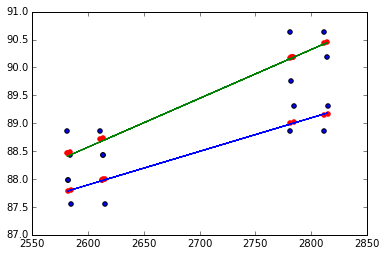

In [90]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
    
plt.scatter(event12.Z.values, event12.Y.values, color='r')
plt.show()

In [14]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [15]:
tracks_params

array([[  6.00731549e-03,   7.22756295e+01],
       [  8.74667597e-03,   6.58294688e+01]])

In [16]:
labels

array([ 1.,  0.,  1.,  0., -1.,  0.,  1.,  1.,  1.,  0., -1.,  0.,  1.,
        1.,  0.,  1.,  0.,  1.,  1.])

In [17]:
event12.Label.values

array([ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.])

### Tracks Reconstruction

In [47]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = ImprovedTemplateMatching(n_tracks=2, n_max_hits=16, n_min_hits=7, window_width=0.75, lambda_=2.0, T=0.5**2)
    stm_stereo = ImprovedTemplateMatching(n_tracks=1, n_max_hits=16, n_min_hits=6, window_width=15, lambda_=2.0, T=5**2)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 87.8 ms, sys: 29.4 ms, total: 117 ms
Wall time: 2min 10s


In [48]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = Combinator(dy_max=2, dx_max=20)
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)


CPU times: user 19.9 s, sys: 192 ms, total: 20.1 s
Wall time: 20.2 s


In [49]:
combinations_quality.head(10)

,EventID,RecoEff,GhostRate,CloneRate,NCombined
0,4097,1.0,0,0,2
1,2,1.0,0,0,2
2,4267,1.0,0,0,2
3,7,1.0,0,0,2
4,4453,1.0,0,0,2
5,3081,1.0,0,0,2
6,10,1.0,0,0,2
7,2059,1.0,0,0,2
8,1036,1.0,0,0,2
9,3085,0.5,0,0,1


In [50]:
(combinations_quality.head(10).RecoEff.values == 1).sum()

9

In [51]:
tracks_metrics_before_stereo.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1.0,0,0
1,2,1.000000,1.0,0,0
2,4267,1.000000,1.0,0,0
3,7,1.000000,1.0,0,0
4,4453,1.000000,1.0,0,0
5,3081,1.000000,1.0,0,0
6,10,1.000000,1.0,0,0
7,2059,1.000000,1.0,0,0
8,1036,1.000000,1.0,0,0
9,3085,0.727273,0.5,0,0


In [52]:
tracks_metrics_before_y.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1.0,0,0.0
1,2,1.000000,1.0,0,0.0
2,4267,1.000000,1.0,0,0.0
3,7,1.000000,1.0,0,0.0
4,4453,1.000000,1.0,0,0.0
5,3081,1.000000,1.0,0,0.0
6,10,1.000000,1.0,0,0.0
7,2059,1.000000,1.0,0,0.0
8,1036,0.909091,1.0,0,0.0
9,3085,0.818182,0.5,0,0.5


In [53]:
tracks_metrics_before_y[tracks_metrics_before_y.RecoEff != 1].head()

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
9,3085,0.818182,0.5,0.0,0.5
230,3406,0.777778,0.5,0.0,0.5
236,3781,1.000000,0.5,0.5,0.0
436,793,1.000000,0.5,0.5,0.0


# Quality

# Stations 1&2

### Y-views

In [54]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.995657
RecoEff         0.997015
GhostRate       0.001493
CloneRate       0.001493
dtype: float64

### Stereo-views

In [55]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.990043
RecoEff         0.992537
GhostRate       0.002985
CloneRate       0.000746
dtype: float64

### Stations 1&2

In [56]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.991567
RecoEff         0.996269
GhostRate       0.001493
CloneRate       0.002239
dtype: float64

### Track efficiency

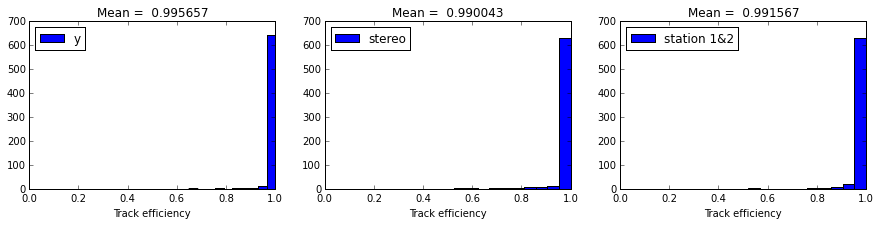

In [57]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

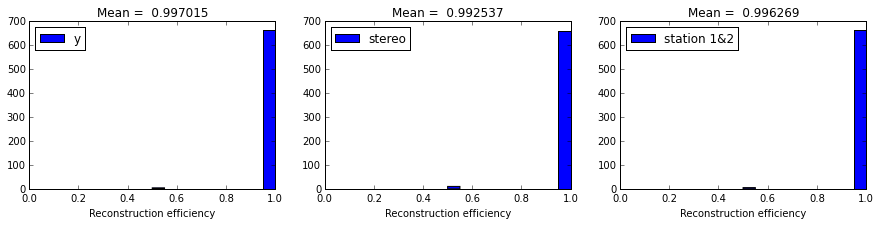

In [58]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [59]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.995790
RecoEff         0.993284
GhostRate       0.004478
CloneRate       0.002239
dtype: float64

### Stereo-views

In [60]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.992002
RecoEff         0.987313
GhostRate       0.005224
CloneRate       0.000000
dtype: float64

### Station 3&4

In [61]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.993045
RecoEff         0.988060
GhostRate       0.004478
CloneRate       0.007463
dtype: float64

### Tracks efficiency

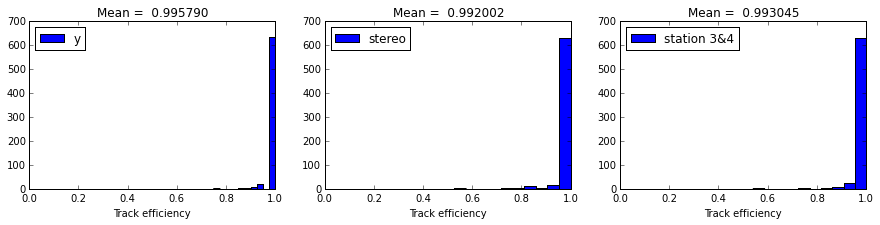

In [62]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

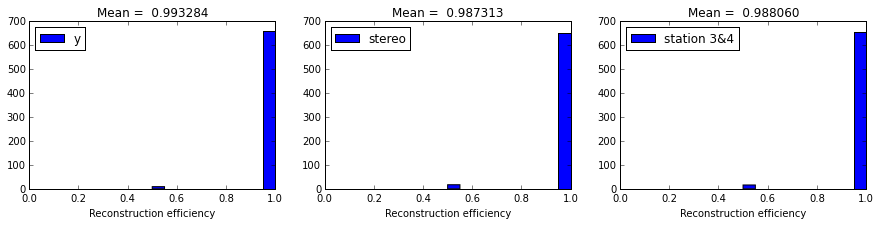

In [63]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [64]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.977612
GhostRate       0.002239
CloneRate       0.000000
NCombined       1.955224
dtype: float64

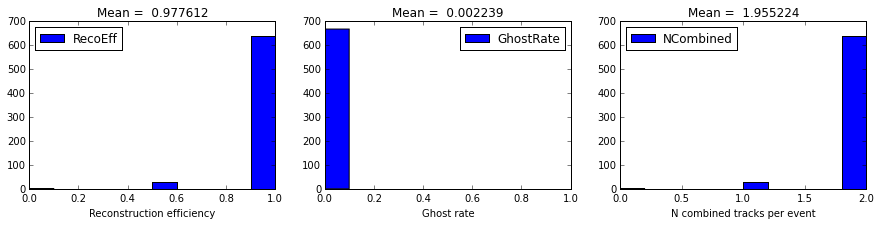

In [65]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

95.671641791


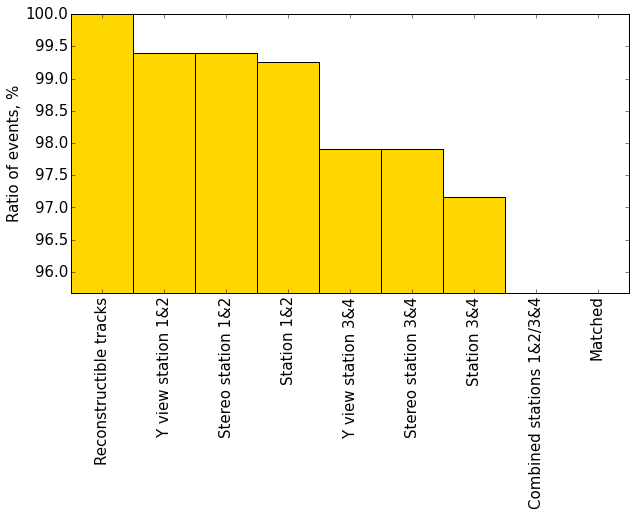

In [66]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [67]:
bar_values

array([ 100.        ,   99.40298507,   99.40298507,   99.25373134,
         97.91044776,   97.91044776,   97.1641791 ,   95.67164179,
         95.67164179])

# Momentum

In [68]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

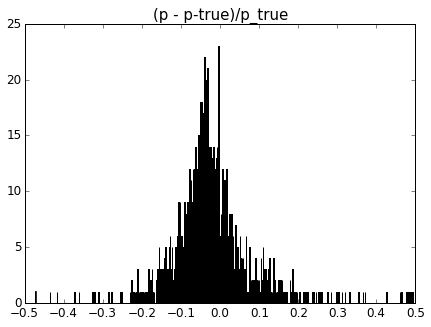

In [69]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=1000)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [70]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

3

# Did not recognized tracks

In [71]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
9,3085,1,0,0,0,0,0,0,0,0
54,85,1,1,1,1,1,1,1,0,0
55,86,1,1,1,1,0,0,0,0,0
58,3161,1,1,1,1,1,1,1,0,0
66,102,1,1,1,1,1,1,1,0,0
78,1142,1,1,1,1,1,1,1,0,0
95,143,1,1,1,1,1,1,0,0,0
122,2232,1,1,1,1,1,1,1,0,0
168,4342,1,1,1,1,1,1,1,0,0
182,2263,1,1,1,1,1,1,1,0,0


In [72]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

3085.0


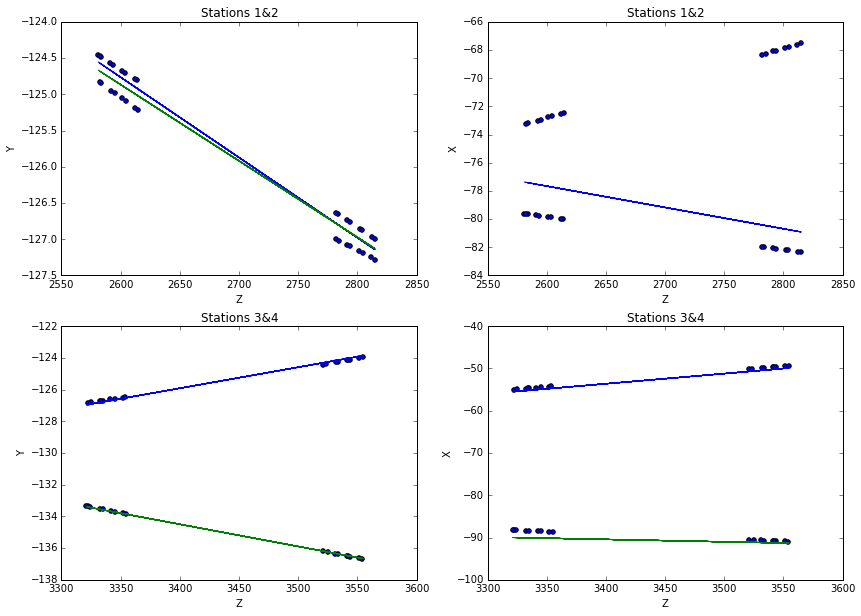

85.0


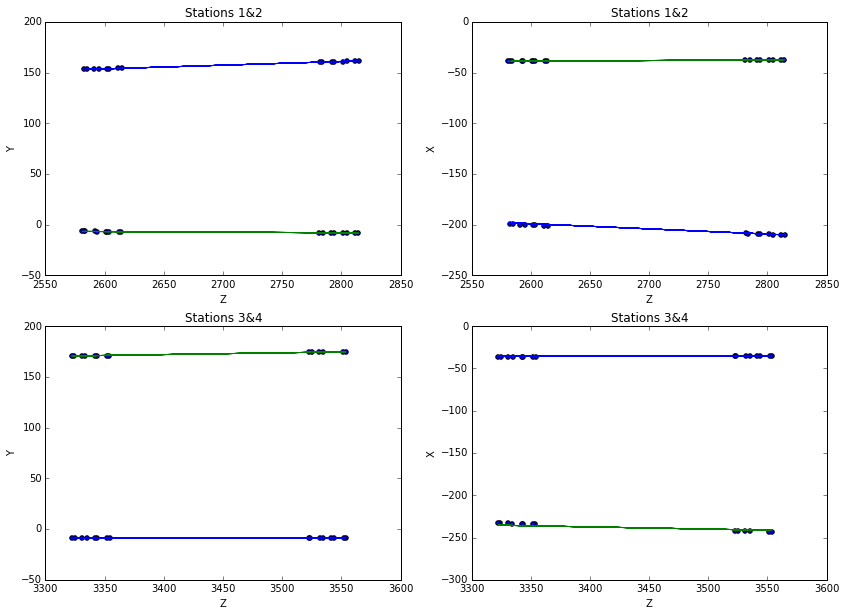

86.0


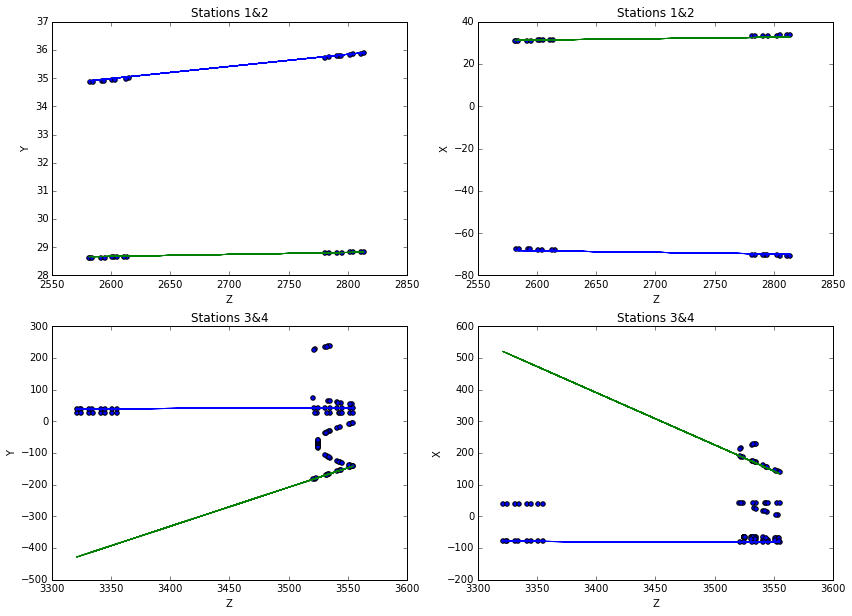

3161.0


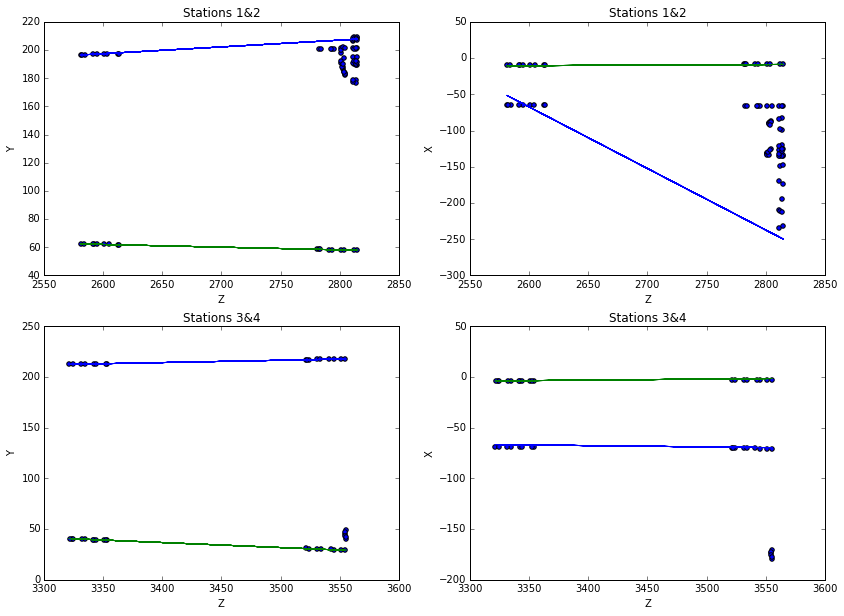

102.0


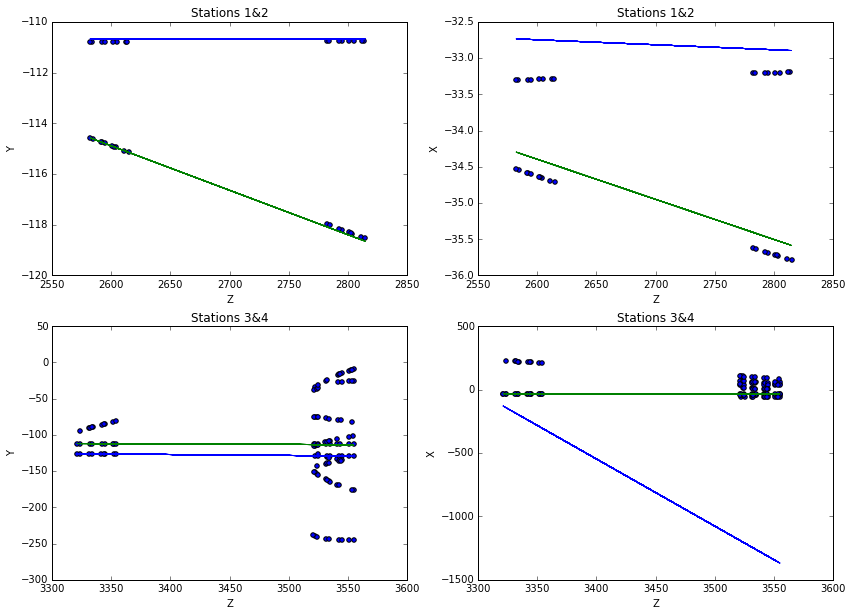

1142.0


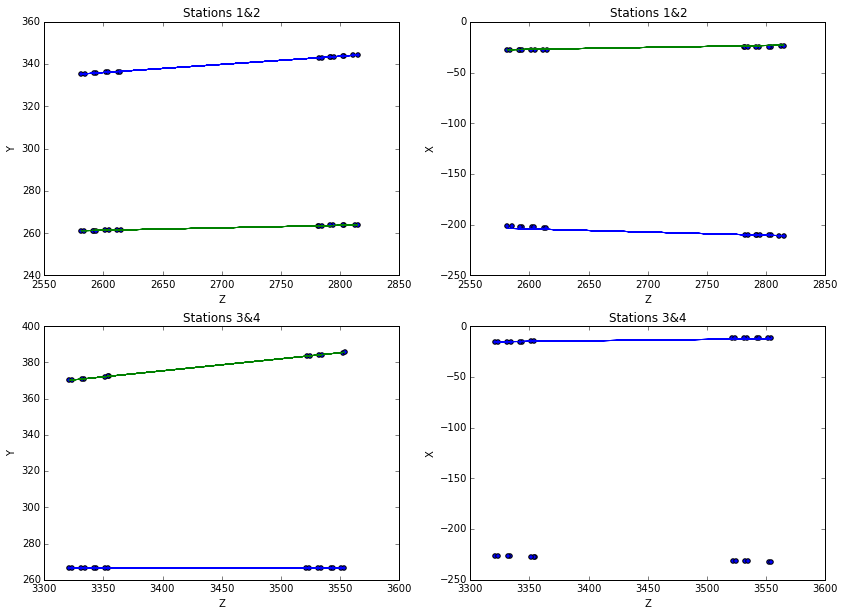

143.0


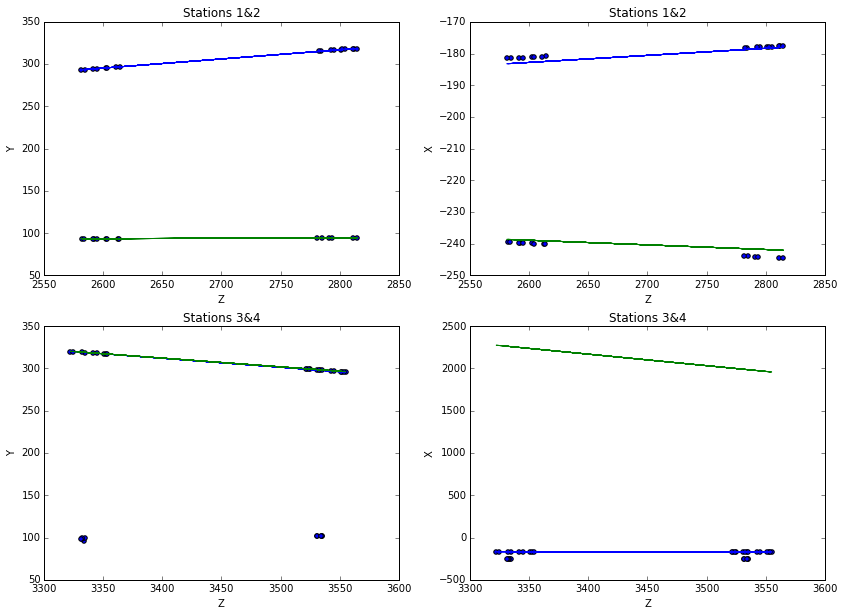

2232.0


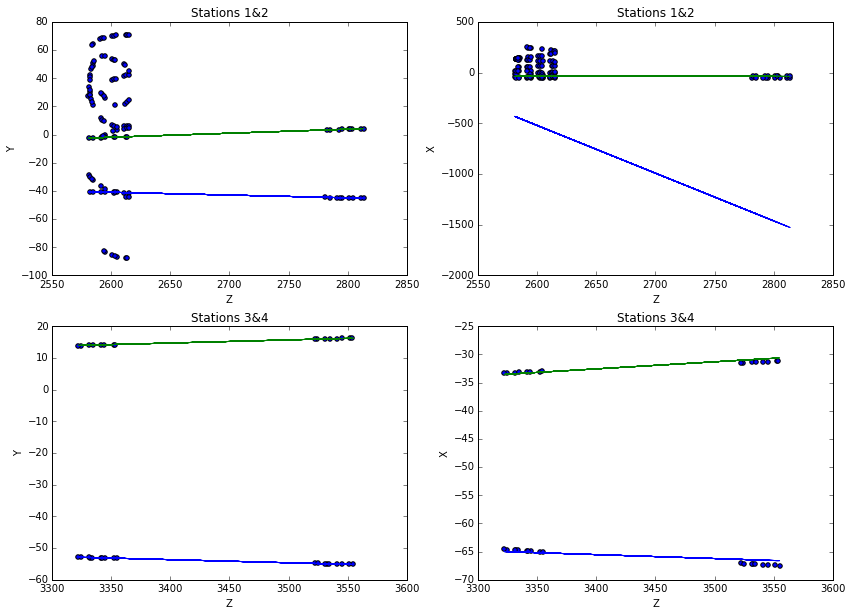

4342.0


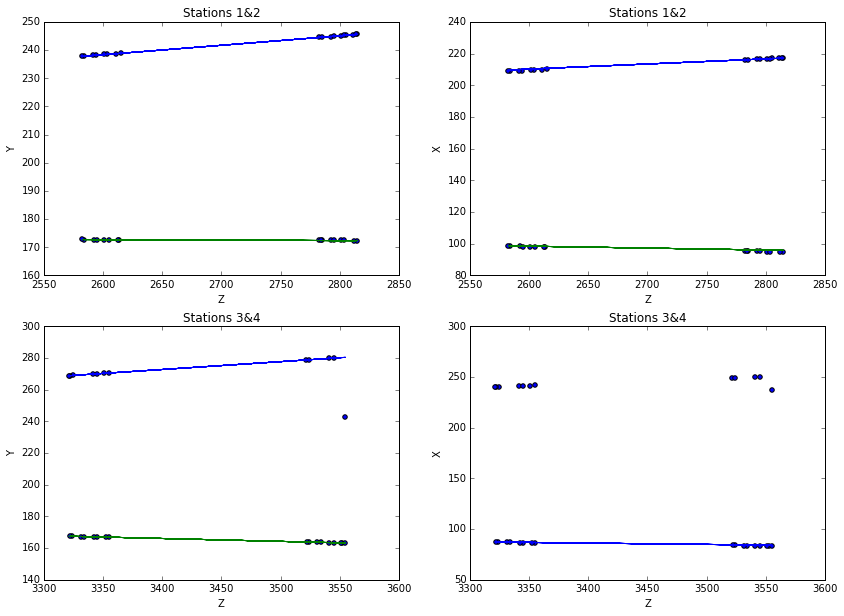

2263.0


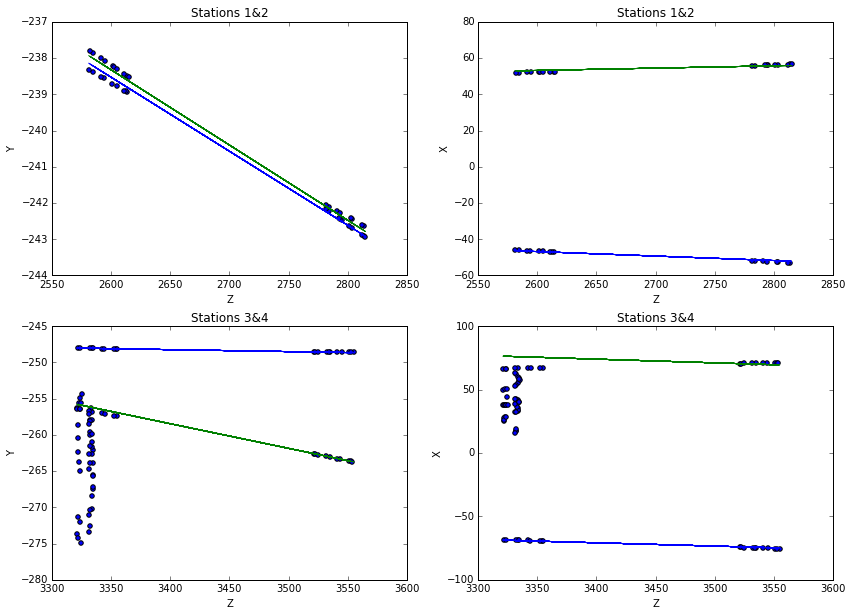

270.0


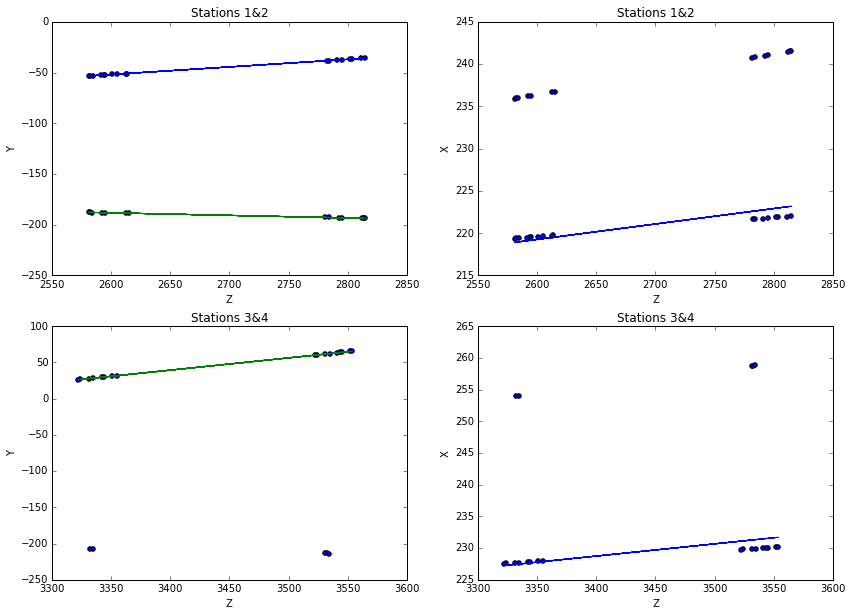

3406.0


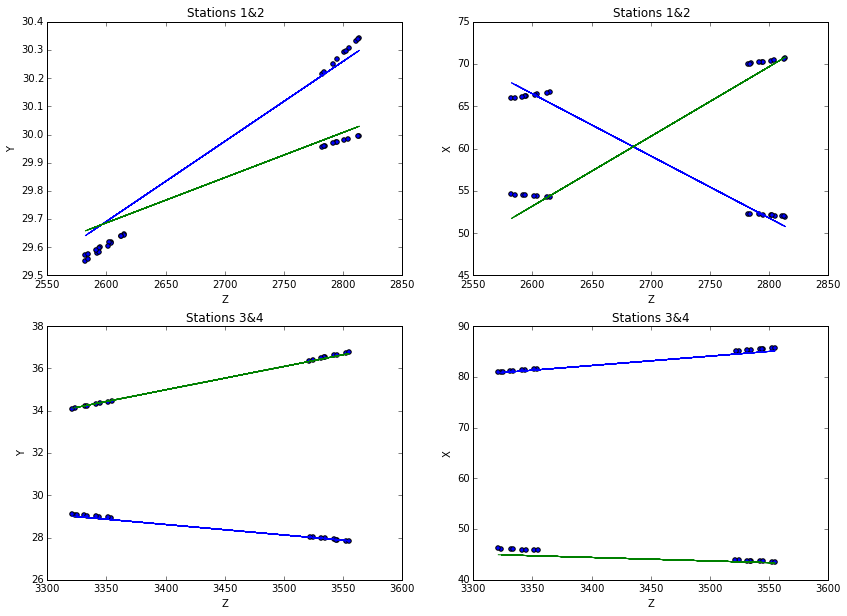

3781.0


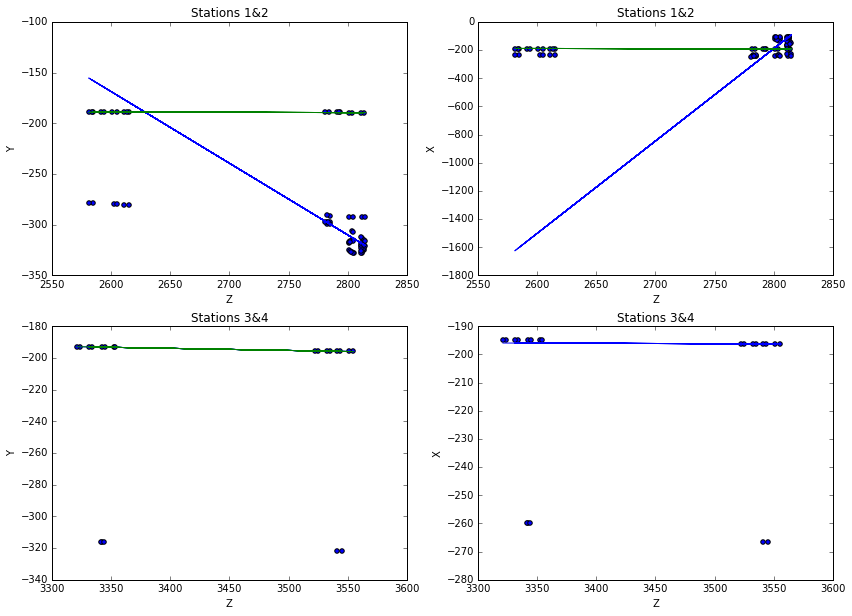

4490.0


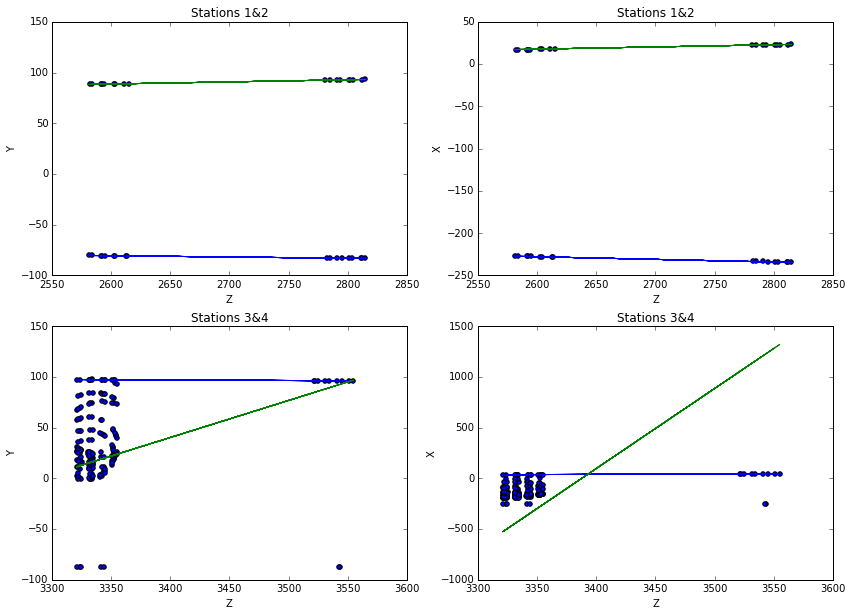

426.0


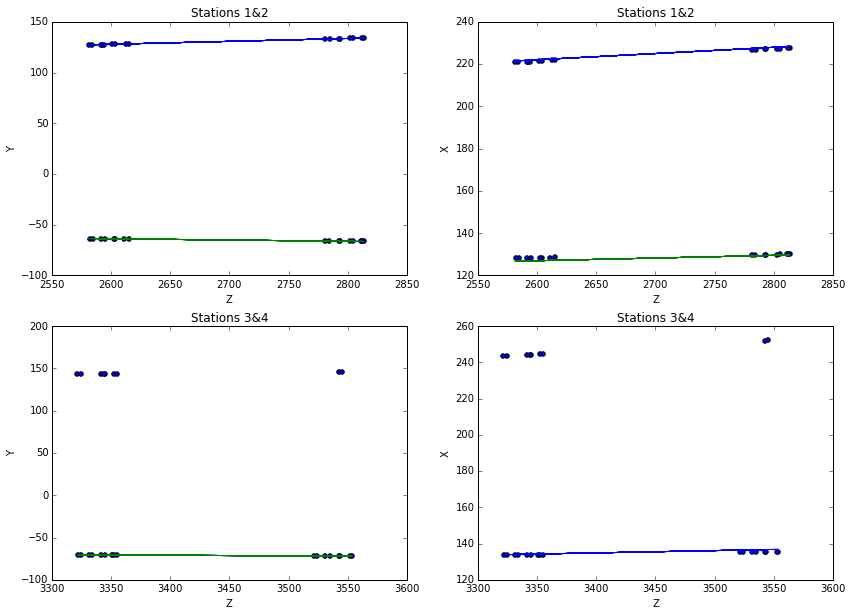

4175.0


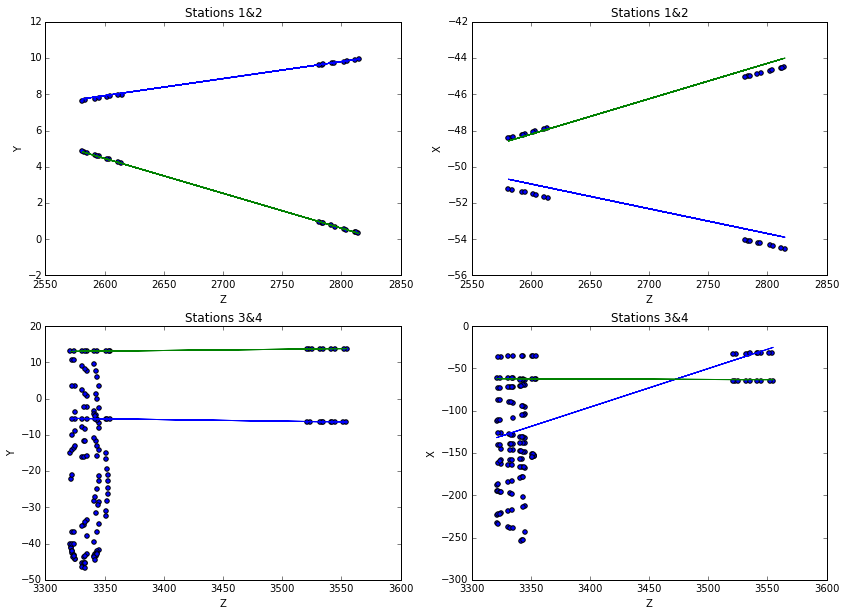

3497.0


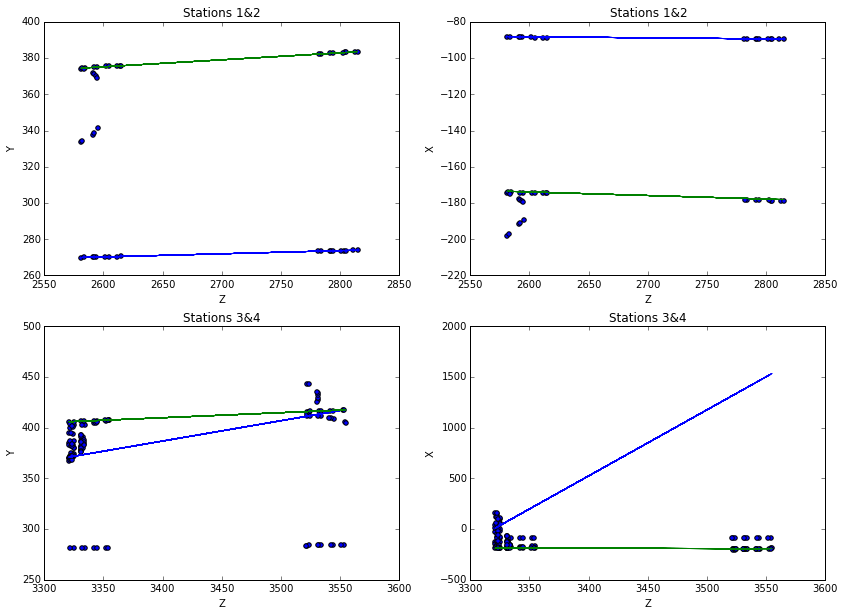

1528.0


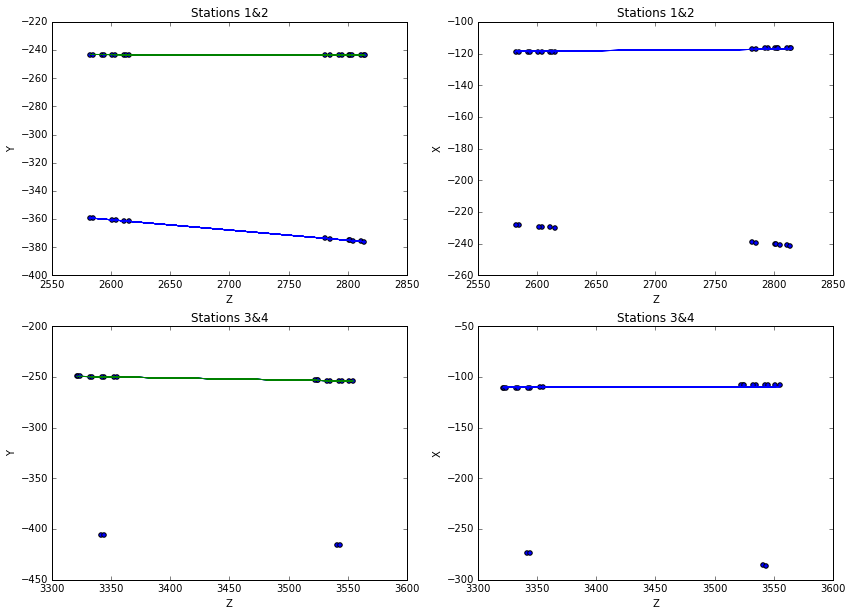

2605.0


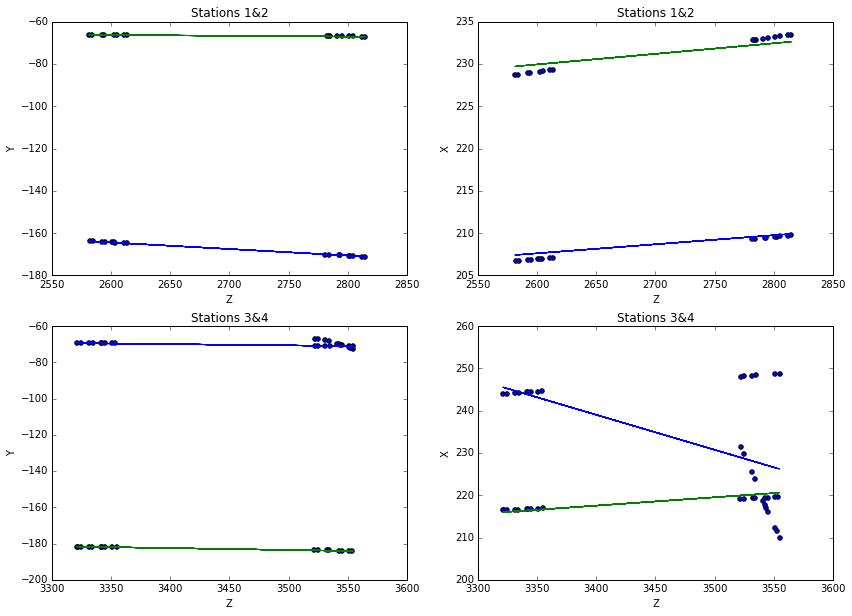

3670.0


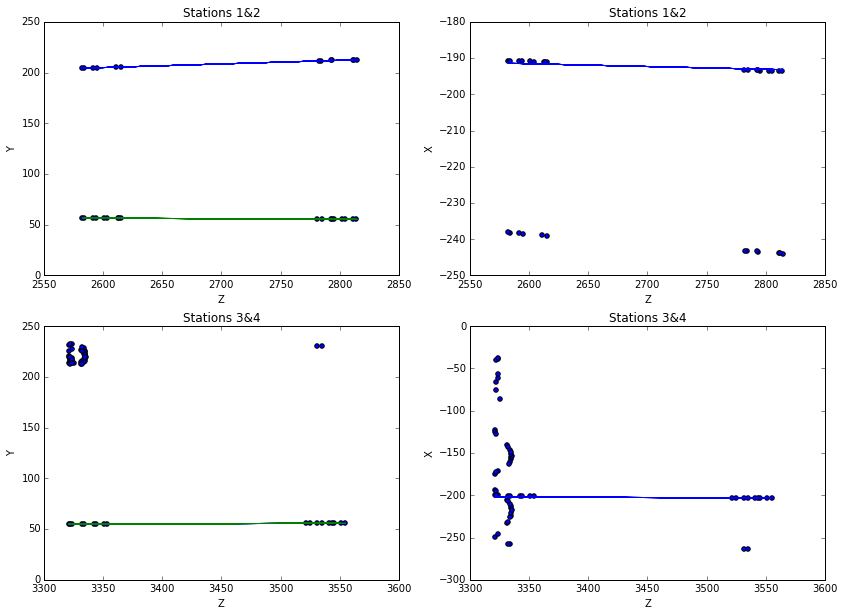

793.0


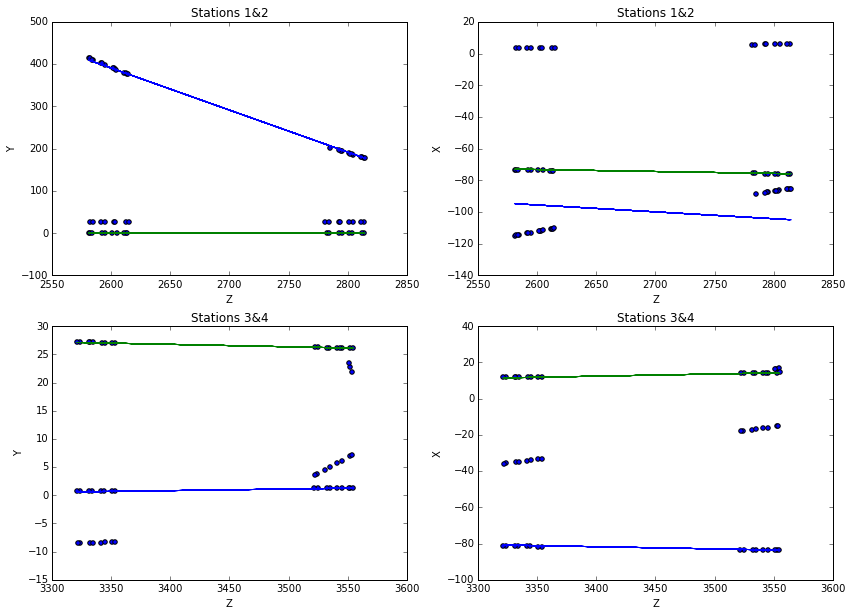

670.0


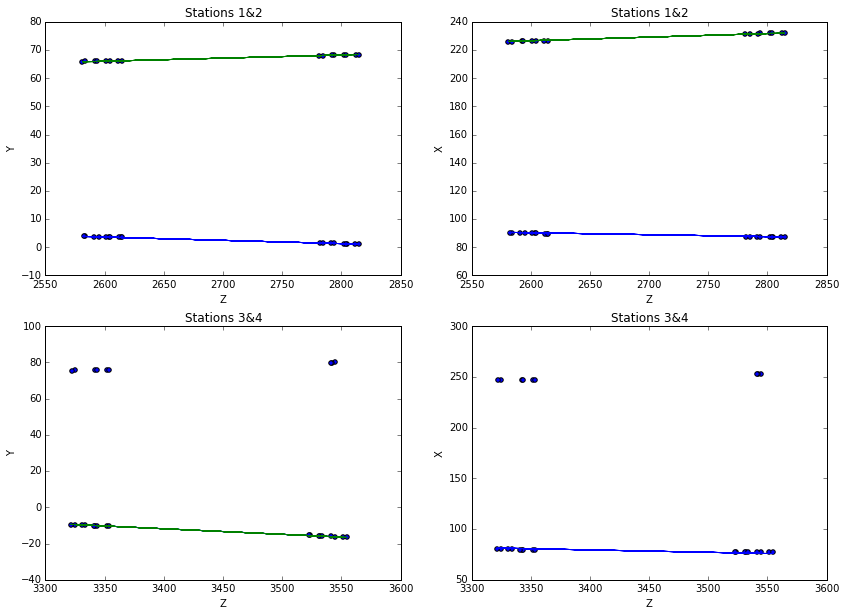

3749.0


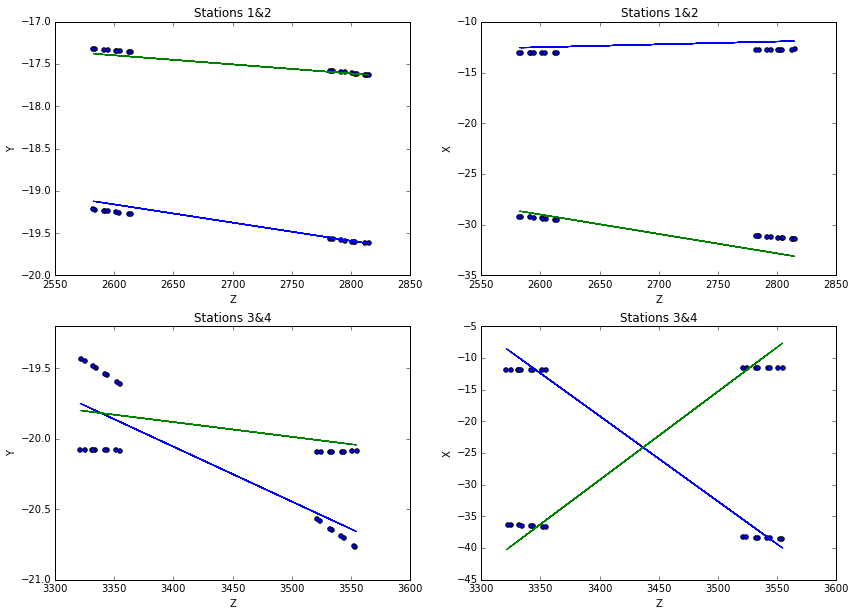

1722.0


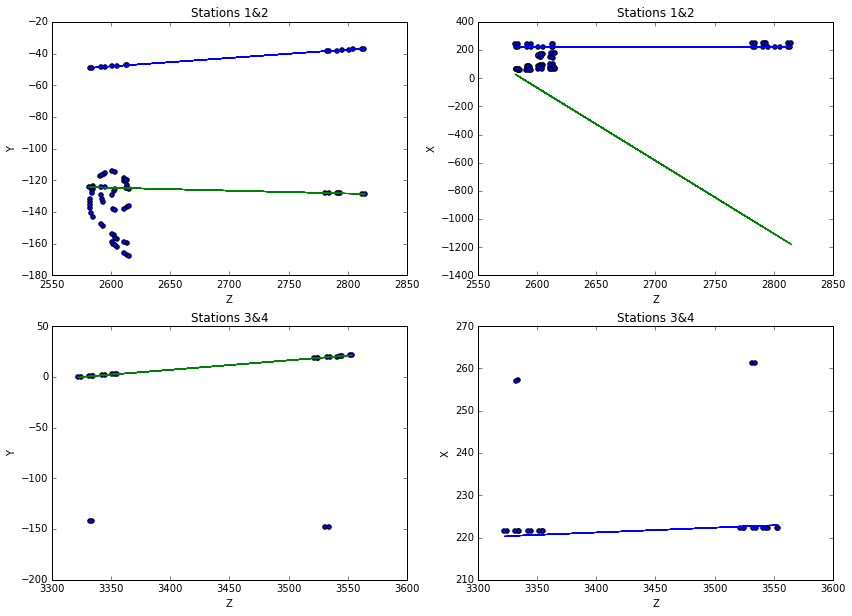

1756.0


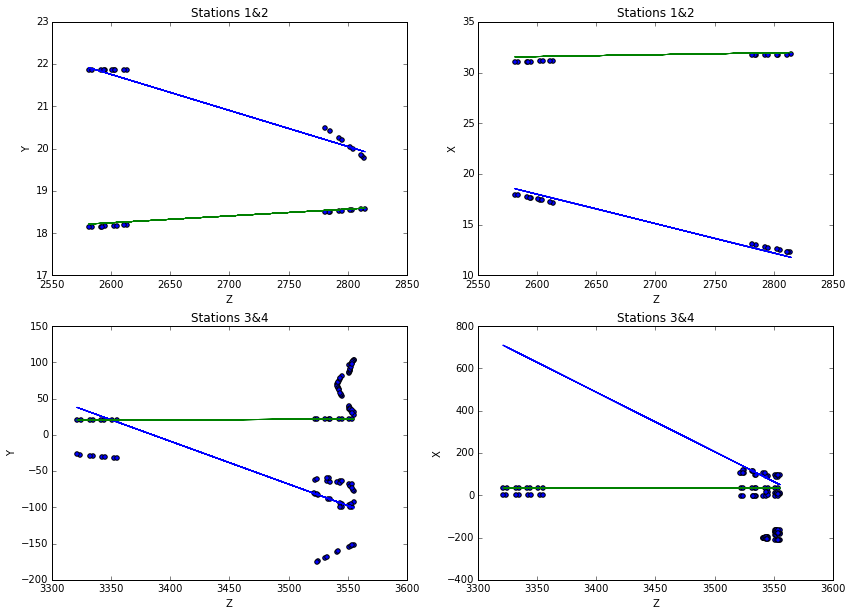

916.0


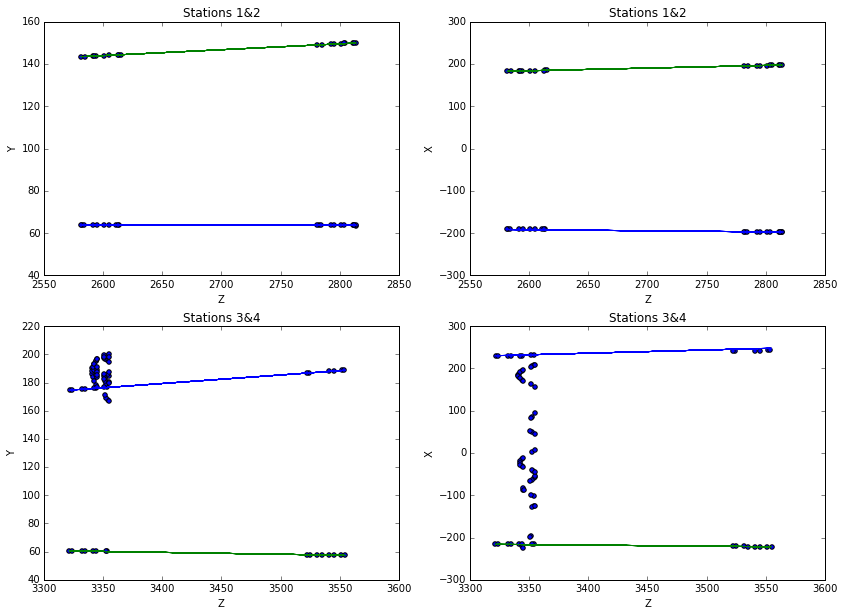

4600.0


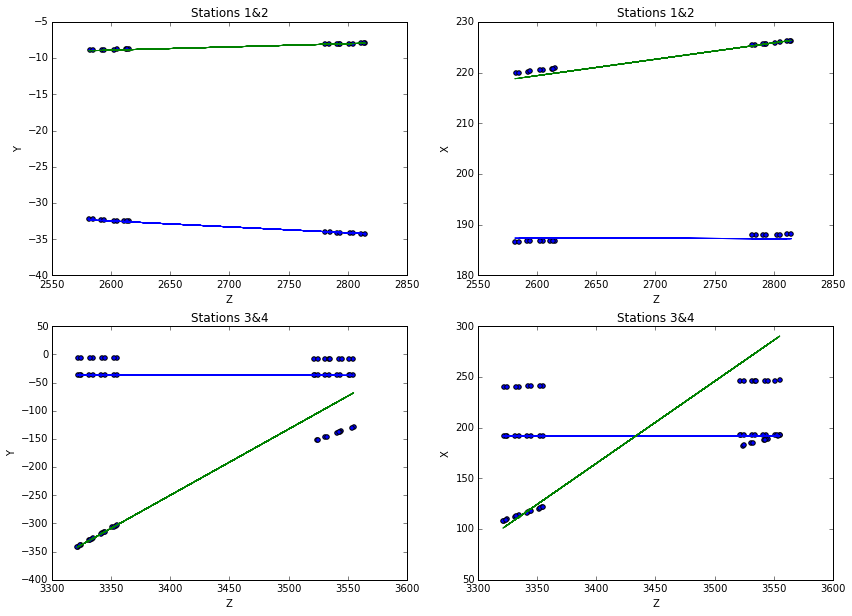

3035.0


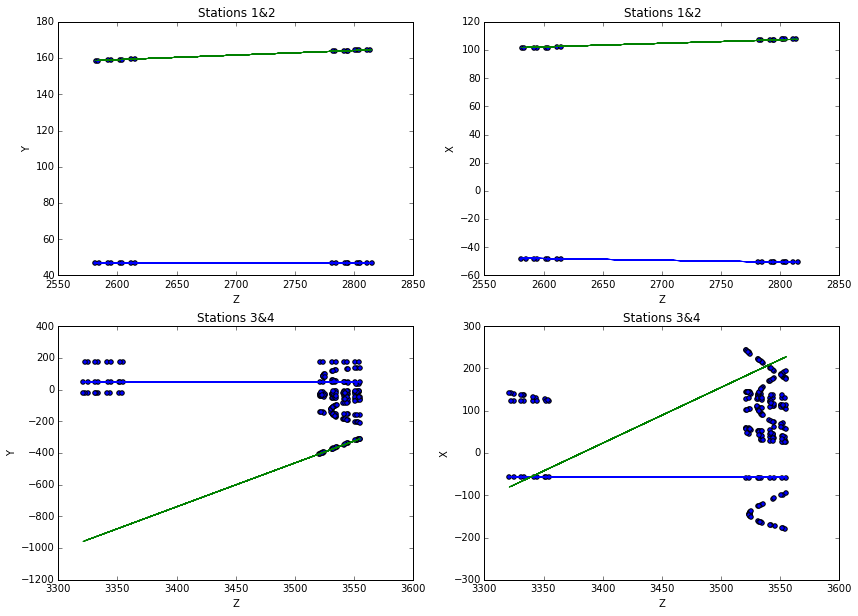

2040.0


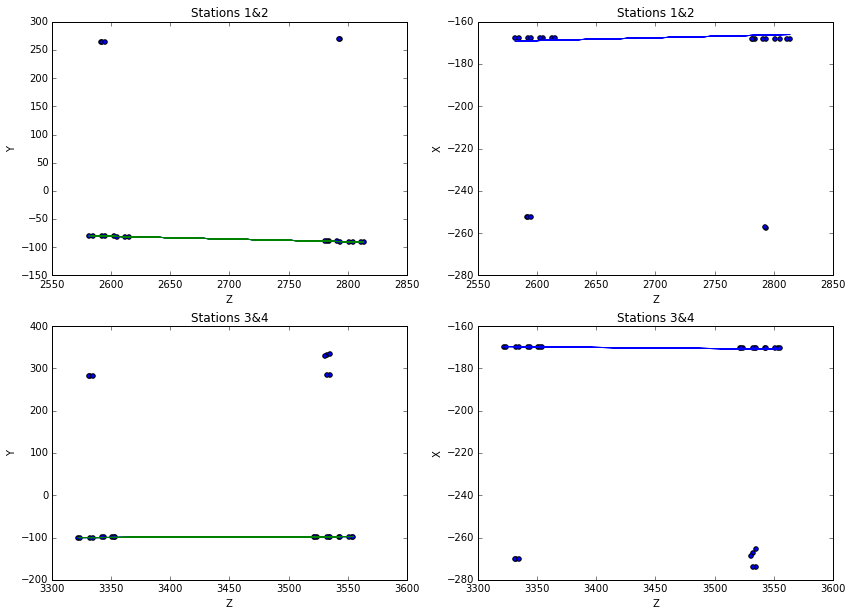

In [73]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)